In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import json
import os
import re
from typing import Tuple, Dict, Any, List

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from transformers import GPT2Model, AutoTokenizer, Wav2Vec2Model, AutoFeatureExtractor
from huggingface_hub import notebook_login
from datasets import load_dataset

In [3]:
notebook_login()

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
hparams = {
    'train_split': '/content/drive/My Drive/Uni/Máster/TFM/tfm_audio_embeddings_chatbot/data/dstc2_train.flist',
    'dev_split': '/content/drive/My Drive/Uni/Máster/TFM/tfm_audio_embeddings_chatbot/data/dstc2_dev.flist',
    'test_split': '/content/drive/My Drive/Uni/Máster/TFM/tfm_audio_embeddings_chatbot/data/dstc2_test.flist',
    'gpt_only_text_dir': '/content/drive/My Drive/Uni/Máster/TFM/tfm_audio_embeddings_chatbot/models/gpt2_transcript_seed_0.pt',
    'seed': 42,
    'num_classes': 60,
    'gpt2_version': 'gpt2',
    'wav2vec2_version': 'facebook/wav2vec2-base-960h',
    'learning_rate': 5e-5,
    'num_epochs': 2,
    'log_interval': 100}

In [6]:
torch.manual_seed(hparams['seed'])

## 1) Load data

#### 1) Dialogues processed

In [7]:
dataset = load_dataset('danielroncel/dstc2_dialogues_input_gpt2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/22266 [00:00<?, ? examples/s]

In [8]:
df = dataset['train'].to_pandas()

del dataset

print(len(df))
df.head()

22266


,session_id,audio_file,chat_history_last_9_tokenized,speaker_text_last_9_tokenized,attention_mask,label_semantics,label_semantics_encoded,label,label_encoded
0,voip-00d76b791d-20130327_010416,pt344x_0000993_0001219.wav,"[50258, 15496, 837, 7062, 284, 262, 14457, 707...","[50258, 50258, 50258, 50258, 50258, 50258, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",inform|area_inform|pricerange,45,request|food,55
1,voip-00d76b791d-20130327_010416,pt344x_0001649_0001680.wav,"[50258, 15496, 837, 7062, 284, 262, 14457, 707...","[50258, 50258, 50258, 50258, 50258, 50258, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",inform|this,76,inform|area_inform|food_inform|pricerange_offe...,35
2,voip-00d76b791d-20130327_010416,pt344x_0002674_0002736.wav,"[50258, 15496, 837, 7062, 284, 262, 14457, 707...","[50258, 50258, 50258, 50258, 50258, 50258, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",request|addr,87,inform|addr_offer|name,34
3,voip-00d76b791d-20130327_010416,pt344x_0003533_0003611.wav,"[50258, 15496, 837, 7062, 284, 262, 14457, 707...","[50258, 50258, 50258, 50258, 50258, 50258, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",request|food,101,inform|area_inform|pricerange_offer|name,40
4,voip-00d76b791d-20130327_011116,pt344x_0001082_0001294.wav,"[50258, 15496, 837, 7062, 284, 262, 14457, 707...","[50258, 50258, 50258, 50258, 50258, 50258, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",inform|area_inform|food,42,request|food,55


In [9]:
df['chat_history_last_9_tokenized'] = df['chat_history_last_9_tokenized'].apply(lambda x: list(x))
df['speaker_text_last_9_tokenized'] = df['speaker_text_last_9_tokenized'].apply(lambda x: list(x))
df['attention_mask'] = df['attention_mask'].apply(lambda x: list(x))

### 1.2) idx2inform

In [10]:
df_label = df[['label', 'label_encoded']]
df_label = df_label.drop_duplicates('label_encoded')\
                   .sort_values(by='label_encoded', ascending=True)
print(len(df_label))
df_label.head()

60


,label,label_encoded
5930,canthelp.exception|name_canthelp|area_canthelp...,0
5546,canthelp.exception|name_canthelp|area_canthelp...,1
5627,canthelp.exception|name_canthelp|area_canthelp...,2
6250,canthelp.exception|name_canthelp|food,3
5800,canthelp.exception|name_canthelp|food_canthelp...,4


In [11]:
idx2inform = list()

for idx, row in df_label.iterrows():

  row_inform = list()

  label = row['label']
  label = label.split('_')

  for item in label:
    if 'inform' in item:
      row_inform.append(item.split('|')[1])

  idx2inform.append(set(row_inform))

idx2inform[20:30]

[set(),
 {'count'},
 {'count'},
 set(),
 {'count'},
 {'count'},
 {'addr', 'food', 'phone'},
 {'addr', 'food'},
 {'addr', 'phone', 'postcode'},
 {'addr', 'phone', 'pricerange'}]

## 3) idx2semantic

In [12]:
df_label = df[['label_semantics', 'label_semantics_encoded']]
df_label = df_label.drop_duplicates('label_semantics_encoded')\
                   .sort_values(by='label_semantics_encoded', ascending=True)
print(len(df_label))
df_label.head()

113


,label_semantics,label_semantics_encoded
14,,0
294,ack,1
17733,ack_inform|food_reqalts,2
5540,ack_inform|this,3
9625,ack_reqalts,4


In [13]:
idx2semantic = list()

for idx, row in df_label.iterrows():

  row_inform = list()

  label = row['label_semantics']
  label = label.split('_')

  for item in label:
    if 'request' in item:
      row_inform.append(item.split('|')[1])

  idx2semantic.append(set(row_inform))

idx2semantic[60:70]

[set(),
 set(),
 set(),
 {'addr', 'area'},
 {'area'},
 {'signature'},
 set(),
 {'addr'},
 {'addr', 'phone'},
 {'food'}]

In [14]:
del df_label

#### 1.2) Audios

In [15]:
dataset = load_dataset('danielroncel/dstc2_audios_input_wav2vec2')

Generating train split:   0%|          | 0/25516 [00:00<?, ? examples/s]

In [16]:
df_audios = dataset['train'].to_pandas()

In [17]:
del dataset

In [18]:
df_audios = df_audios.rename({'session_ids': 'session_id',
                              'path': 'audio_file'}, axis=1)

In [19]:
df_audios.head()

,session_id,audio_file,input_values
0,voip-00d76b791d-20130327_010416,pt344x_0000993_0001219.wav,"[0.0084459325, 0.0084459325, 0.0025093406, -0...."
1,voip-00d76b791d-20130327_010416,pt344x_0001649_0001680.wav,"[0.0034742623, 0.00435598, 0.009646287, 0.0096..."
2,voip-00d76b791d-20130327_010416,pt344x_0002674_0002736.wav,"[0.0030231818, 0.0030231818, 0.006158771, 0.01..."
3,voip-00d76b791d-20130327_010416,pt344x_0003533_0003611.wav,"[0.005288514, 0.01527205, 0.018902427, 0.01527..."
4,voip-00d76b791d-20130327_010416,pt344x_0004453_0004531.wav,"[0.005022339, 0.008258534, 0.0066404366, 0.002..."


#### 1.3) Merge text and audio

In [20]:
print(df.shape[0])
df = df.merge(df_audios, on=['audio_file', 'session_id'], how='inner')\
       .drop(['audio_file',], axis=1)
print(df.shape[0])

del df_audios

df.head()

22266
22266


,session_id,chat_history_last_9_tokenized,speaker_text_last_9_tokenized,attention_mask,label_semantics,label_semantics_encoded,label,label_encoded,input_values
0,voip-00d76b791d-20130327_010416,"[50258, 15496, 837, 7062, 284, 262, 14457, 707...","[50258, 50258, 50258, 50258, 50258, 50258, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",inform|area_inform|pricerange,45,request|food,55,"[0.0084459325, 0.0084459325, 0.0025093406, -0...."
1,voip-00d76b791d-20130327_010416,"[50258, 15496, 837, 7062, 284, 262, 14457, 707...","[50258, 50258, 50258, 50258, 50258, 50258, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",inform|this,76,inform|area_inform|food_inform|pricerange_offe...,35,"[0.0034742623, 0.00435598, 0.009646287, 0.0096..."
2,voip-00d76b791d-20130327_010416,"[50258, 15496, 837, 7062, 284, 262, 14457, 707...","[50258, 50258, 50258, 50258, 50258, 50258, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",request|addr,87,inform|addr_offer|name,34,"[0.0030231818, 0.0030231818, 0.006158771, 0.01..."
3,voip-00d76b791d-20130327_010416,"[50258, 15496, 837, 7062, 284, 262, 14457, 707...","[50258, 50258, 50258, 50258, 50258, 50258, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",request|food,101,inform|area_inform|pricerange_offer|name,40,"[0.005288514, 0.01527205, 0.018902427, 0.01527..."
4,voip-00d76b791d-20130327_011116,"[50258, 15496, 837, 7062, 284, 262, 14457, 707...","[50258, 50258, 50258, 50258, 50258, 50258, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",inform|area_inform|food,42,request|food,55,"[-6.28221e-05, -0.0015946792, -0.0015946792, -..."


## 2) Train/Test split

In [21]:
assert df['label'].nunique() == hparams['num_classes']

In [22]:
# load train session ids
with open(hparams['train_split'], 'r') as file:
  lines = file.readlines()

  train_session_ids = list()
  for line in lines:
    line = line.strip()

    session_id = re.search(r'Mar\d{2}_S\dA\d\/(.*)', line).group(1)
    train_session_ids.append(session_id)

In [23]:
# load dev session ids
with open(hparams['dev_split'], 'r') as file:
  lines = file.readlines()

  dev_session_ids = list()
  for line in lines:
    line = line.strip()

    session_id = re.search(r'Mar\d{2}_S\dA\d\/(.*)', line).group(1)
    dev_session_ids.append(session_id)

In [24]:
# load test session ids
with open(hparams['test_split'], 'r') as file:
  lines = file.readlines()

  test_session_ids = list()
  for line in lines:
    line = line.strip()

    session_id = re.search(r'Mar\d{2}_S\dA\d\/(.*)', line).group(1)
    test_session_ids.append(session_id)

In [25]:
# built the final test set by adding the dev set, as done in the paper
#test_session_ids = test_session_ids + dev_session_ids

In [26]:
print(f"Train samples: {len(train_session_ids)}")
print(f"Dev samples: {len(dev_session_ids)}")
print(f"Test samples: {len(test_session_ids)}")

Train samples: 1612
Dev samples: 506
Test samples: 1117


In [27]:
df_train = df[df['session_id'].isin(train_session_ids)]
df_dev = df[df['session_id'].isin(dev_session_ids)]
df_test = df[df['session_id'].isin(test_session_ids)]

print(f"Train messages: {len(df_train)} ({df_train['session_id'].nunique()} dialogues)")
print(f"Dev messages: {len(df_dev)} ({df_dev['session_id'].nunique()} dialogues)")
print(f"Test messages: {len(df_test)} ({df_test['session_id'].nunique()} dialogues)")

Train messages: 10065 (1612 dialogues)
Dev messages: 3428 (506 dialogues)
Test messages: 8773 (1117 dialogues)


In [28]:
del train_session_ids, dev_session_ids, test_session_ids

## 2) Define dataset and model

#### 2.1) Load pretrained model text-only

In [29]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")

new_tokens = ["<sys>", "<user>" ,"<DA_pred>"]

# check if the tokens are already in the vocabulary
new_tokens = set(new_tokens) - set(tokenizer.vocab.keys())

# modify the tokenizer to take into account the new token
tokenizer.add_tokens(list(new_tokens))

# Add padding token
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

1

In [30]:
class GPT2Classifier(nn.Module):
    def __init__(self, num_classes):
        super(GPT2Classifier, self).__init__()

        self.gpt2 = GPT2Model.from_pretrained(hparams['gpt2_version'])

        self.linear = nn.Linear(self.gpt2.config.hidden_size, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=-1)

        self.gpt2.resize_token_embeddings(len(tokenizer))

    def forward(self, chat_history_tokens, speaker_tokens, attention_mask):

        # get token embedding
        word_embedding = self.gpt2.wte(chat_history_tokens)
        # get speaker embedding
        speaker_embedding = self.gpt2.wte(speaker_tokens)

        input_embedding = word_embedding + speaker_embedding

        output = self.gpt2(inputs_embeds=input_embedding,
                           attention_mask=attention_mask)

        last_hidden_states = output.last_hidden_state

        chat_history_embedding = last_hidden_states[:, -1, :]

        output = self.linear(chat_history_embedding)

        output = self.log_softmax(output)

        return output

#### 2.2) Define dataset

In [31]:
class DSTC2(Dataset):
    def __init__(self, data):

        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        chat_history_tokens_tensor = torch.tensor(self.data['chat_history_last_9_tokenized'].iloc[idx])
        speaker_tokens_tensor = torch.tensor(self.data['speaker_text_last_9_tokenized'].iloc[idx])
        attention_mask_tensor = torch.tensor(self.data['attention_mask'].iloc[idx])
        audio = torch.tensor(self.data['input_values'].iloc[idx])

        semantics = torch.tensor(self.data['label_semantics_encoded'].iloc[idx], dtype=torch.int32)
        labels = torch.tensor(self.data['label_encoded'].iloc[idx], dtype=torch.int32)

        return chat_history_tokens_tensor, speaker_tokens_tensor, attention_mask_tensor, audio, semantics, labels

In [32]:
del df, session_id, new_tokens, lines, line, file

In [33]:
df_train = df_train.reset_index(drop=True)
df_dev = df_dev.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [34]:
train_dataset = DSTC2(df_train)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

dev_dataset = DSTC2(df_dev)
dev_loader = DataLoader(dev_dataset, batch_size=100, shuffle=True)

test_dataset = DSTC2(df_test)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [35]:
class GPT2Wav2Vec2Classifier(nn.Module):
    def __init__(self, num_classes):
        super(GPT2Wav2Vec2Classifier, self).__init__()

        self.gpt2 = GPT2Classifier(num_classes)
        self.gpt2.load_state_dict(
                      torch.load(hparams['gpt_only_text_dir'],
                                 map_location=torch.device('cpu')))
        self.gpt2 = self.gpt2.gpt2

        self.wav2vec2 = Wav2Vec2Model.from_pretrained(hparams['wav2vec2_version'])

        self.linear = nn.Linear(self.gpt2.config.hidden_size + self.wav2vec2.config.hidden_size, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, chat_history_tokens, speaker_tokens, attention_mask, audio):

        # get token embedding
        word_embedding = self.gpt2.wte(chat_history_tokens)
        # get speaker embedding
        speaker_embedding = self.gpt2.wte(speaker_tokens)

        input_embedding = word_embedding + speaker_embedding

        output_gpt2 = self.gpt2(inputs_embeds=input_embedding,
                                attention_mask=attention_mask)

        last_hidden_states = output_gpt2.last_hidden_state

        chat_history_embedding = last_hidden_states[:, -1, :]

        audio_embedding = self.wav2vec2(audio, output_hidden_states=True)

        audio_embedding = audio_embedding.hidden_states[7]

        audio_embedding = audio_embedding.mean(dim=1)

        final_embedding = torch.cat((chat_history_embedding, audio_embedding), dim=1)

        output = self.linear(final_embedding)

        output = self.log_softmax(output)

        return output

In [36]:
model = GPT2Wav2Vec2Classifier(num_classes=hparams['num_classes'])

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 3) Train

In [37]:
def compute_accuracy(predicted_batch: torch.Tensor, label_batch: torch.Tensor) -> float:
    """
    Define the Accuracy metric in the function below by:
      (1) obtain the maximum for each predicted element in the batch to get the
        class (it is the maximum index of the num_classes array per batch sample)
        (look at torch.argmax in the PyTorch documentation)
      (2) compare the predicted class index with the index in its corresponding
        neighbor within label_batch
      (3) sum up the number of affirmative comparisons and return the summation

    Parameters:
    -----------
    predicted_batch: torch.Tensor shape: [BATCH_SIZE, N_CLASSES]
        Batch of predictions
    label_batch: torch.Tensor shape: [BATCH_SIZE, 1]
        Batch of labels / ground truths.
    """
    pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    acum = pred.eq(label_batch.view_as(pred)).sum().item()
    return acum

In [38]:
def user_request_score(predicted_batch: torch.Tensor, semantic_batch: torch.Tensor) -> float:

    global idx2inform, idx2semantic

    pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability

    pred = pred.tolist()
    semantic_batch = semantic_batch.tolist()

    total_correct_sys_answers = 0
    total_user_requests = 0

    for i in range(len(semantic_batch)):
      user_requests = idx2semantic[semantic_batch[i]]
      sys_informs = idx2inform[pred[i][0]]

      correct_sys_answers = sys_informs.intersection(user_requests)

      total_correct_sys_answers += len(correct_sys_answers)
      total_user_requests += len(user_requests)

    return total_correct_sys_answers, total_user_requests

In [39]:
def train_epoch(
        train_loader: torch.utils.data.DataLoader,
        network: torch.nn.Module,
        optimizer: torch.optim,
        criterion: torch.nn.functional,
        epoch: int,
        log_interval: int,
        ) -> Tuple[float, float]:

    # Activate the train=True flag inside the model
    network.train()

    for param in model.gpt2.parameters():
      param.requires_grad = False
    for param in model.wav2vec2.parameters():
      param.requires_grad = False

    train_loss = []

    # acc = 0.0
    acc = list()

    # total_correct_sys_answers = 0
    # total_user_requests = 0
    total_correct_sys_answers = list()
    total_user_requests = list()

    for batch_idx, (chat_history_tokens_tensor, speaker_tokens_tensor, attention_mask_tensor, audio, semantic, target) in enumerate(train_loader, 1):

        chat_history_tokens_tensor = chat_history_tokens_tensor.to(device)
        speaker_tokens_tensor = speaker_tokens_tensor.to(device)
        attention_mask_tensor = attention_mask_tensor.to(device)
        audio = audio.to(device)
        semantic = semantic.type(torch.LongTensor).to(device)

        target = target.type(torch.LongTensor).to(device)

        optimizer.zero_grad()
        output = network(chat_history_tokens_tensor, speaker_tokens_tensor, attention_mask_tensor, audio)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

         # Compute metrics
        #acc += compute_accuracy(output, target)
        acc.append(compute_accuracy(output, target))
        correct_sys_answers, user_requests = user_request_score(output, semantic)
        # total_correct_sys_answers += correct_sys_answers
        # total_user_requests += user_requests
        total_correct_sys_answers.append(correct_sys_answers)
        total_user_requests.append(user_requests)
        train_loss.append(loss.item())

        if batch_idx % log_interval == 0 or batch_idx >= len(train_loader):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAvg Loss: {:.6f}\tAvg Acc: {:.6f}%\tAvg URS: {:.6f}%'.format(
                epoch, batch_idx * len(chat_history_tokens_tensor), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                np.mean(train_loss[-log_interval:]),
                100. * sum(acc[-log_interval:]) / (log_interval * 4),
                100. * sum(total_correct_sys_answers[-log_interval:]) / sum(total_user_requests[-log_interval:])))

    avg_acc = 100. * sum(acc) / len(train_loader.dataset)
    avg_urs = 100. * sum(total_correct_sys_answers) / sum(total_user_requests)

    return np.mean(train_loss), avg_acc, avg_urs

In [40]:
@torch.no_grad() # decorator: avoid computing gradients
def eval_epoch(
        test_loader: torch.utils.data.DataLoader,
        network: torch.nn.Module,
        criterion: torch.nn.functional,
        ) -> Tuple[float, float]:

    # Dectivate the train=True flag inside the model
    network.eval()

    test_loss = 0
    acc = 0
    total_correct_sys_answers = 0
    total_user_requests = 0

    for (chat_history_tokens_tensor, speaker_tokens_tensor, attention_mask_tensor, audio, semantic, target) in test_loader:

        chat_history_tokens_tensor = chat_history_tokens_tensor.to(device)
        speaker_tokens_tensor = speaker_tokens_tensor.to(device)
        attention_mask_tensor = attention_mask_tensor.to(device)
        audio = audio.to(device)
        semantic = semantic.type(torch.LongTensor).to(device)
        target = target.type(torch.LongTensor).to(device)

        output = network(chat_history_tokens_tensor, speaker_tokens_tensor, attention_mask_tensor, audio)

        # Apply the loss criterion and accumulate the loss
        test_loss += criterion(output, target).item()

        # compute number of correct predictions in the batch
        acc += compute_accuracy(output, target)
        correct_sys_answers, user_requests = user_request_score(output, semantic)
        total_correct_sys_answers += correct_sys_answers
        total_user_requests += user_requests

    test_loss /= len(test_loader)
    # Average accuracy across all correct predictions batches now
    test_acc = 100. * acc / len(test_loader.dataset)
    test_urs = 100. * total_correct_sys_answers / total_user_requests
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.6f}%) , URS: {}/{} ({:.6f}%)\n'.format(
        test_loss, acc, len(test_loader.dataset), test_acc, total_correct_sys_answers, total_user_requests, test_urs
        ))
    return test_loss, test_acc, test_urs

In [41]:
optimizer = optim.Adam(model.parameters(), lr=hparams['learning_rate'])
criterion = nn.NLLLoss()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [42]:
tr_losses = []
tr_accs = []
tr_urss = []
dev_losses = []
dev_accs = []
dev_urss = []

model.to(device)

for epoch in range(1, hparams['num_epochs'] + 1):
  tr_loss, tr_acc, train_urs = train_epoch(train_loader, model, optimizer, criterion, epoch, hparams['log_interval'])
  dev_loss, dev_acc, dev_urs = eval_epoch(dev_loader, model, criterion)

  tr_losses.append(tr_loss)
  tr_accs.append(tr_acc)
  tr_urss.append(train_urs)

  dev_losses.append(dev_loss)
  dev_accs.append(dev_acc)
  dev_urss.append(dev_urs)

Train Epoch: 1 [400/10065 (4%)]	Loss: 3.327324	Avg Loss: 4.025181	Avg Acc: 8.250000%	Avg URS: 14.598540%
Train Epoch: 1 [800/10065 (8%)]	Loss: 2.133707	Avg Loss: 2.855194	Avg Acc: 34.000000%	Avg URS: 54.838710%
Train Epoch: 1 [1200/10065 (12%)]	Loss: 2.801645	Avg Loss: 2.229138	Avg Acc: 46.750000%	Avg URS: 73.943662%
Train Epoch: 1 [1600/10065 (16%)]	Loss: 1.474228	Avg Loss: 1.874705	Avg Acc: 53.500000%	Avg URS: 71.523179%
Train Epoch: 1 [2000/10065 (20%)]	Loss: 1.098673	Avg Loss: 1.507854	Avg Acc: 63.250000%	Avg URS: 81.756757%
Train Epoch: 1 [2400/10065 (24%)]	Loss: 0.873076	Avg Loss: 1.375470	Avg Acc: 61.250000%	Avg URS: 87.500000%
Train Epoch: 1 [2800/10065 (28%)]	Loss: 0.569059	Avg Loss: 1.346868	Avg Acc: 64.500000%	Avg URS: 87.671233%
Train Epoch: 1 [3200/10065 (32%)]	Loss: 0.720507	Avg Loss: 1.200853	Avg Acc: 67.000000%	Avg URS: 85.135135%
Train Epoch: 1 [3600/10065 (36%)]	Loss: 1.011170	Avg Loss: 1.033214	Avg Acc: 70.750000%	Avg URS: 85.611511%
Train Epoch: 1 [4000/10065 (40%)]

## 4) Evaluation

### Train

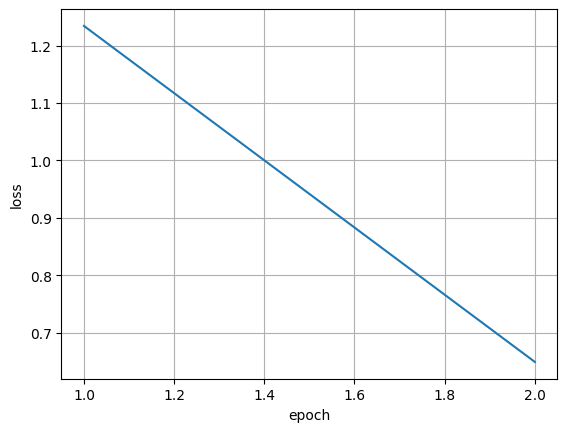

In [43]:
plt.plot([i for i in range(1, hparams['num_epochs']+1)], tr_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

In [44]:
tr_losses

[1.2340770230721423, 0.6495057036537776]

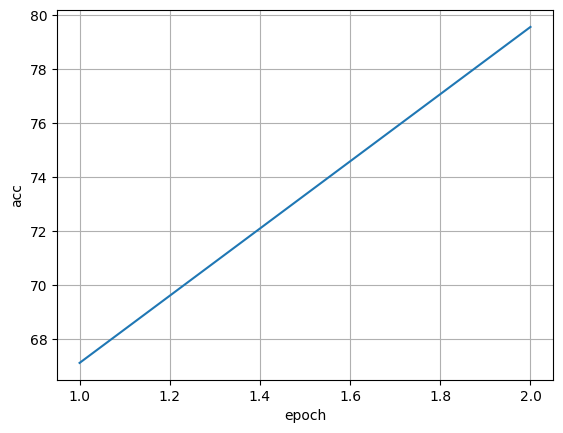

In [45]:
plt.plot([i for i in range(1, hparams['num_epochs']+1)], tr_accs)
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid()

In [46]:
print(tr_accs)

[67.12369597615499, 79.56284153005464]


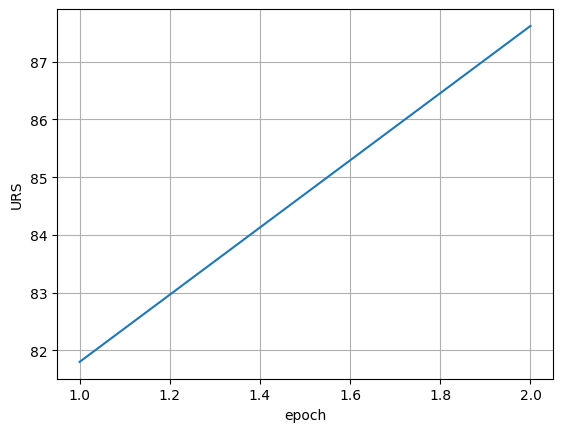

In [47]:
plt.plot([i for i in range(1, hparams['num_epochs']+1)], tr_urss)
plt.xlabel('epoch')
plt.ylabel('URS')
plt.grid()

In [48]:
tr_urss

[81.80071369750206, 87.62009332967335]

### Dev

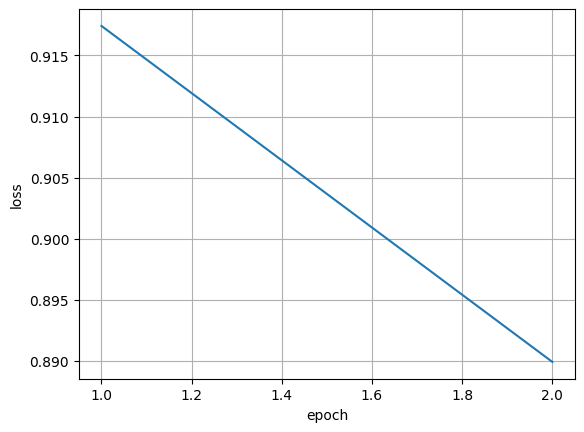

In [49]:
plt.plot([i for i in range(1, hparams['num_epochs']+1)], dev_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

In [50]:
dev_losses

[0.9174150466918946, 0.889909793649401]

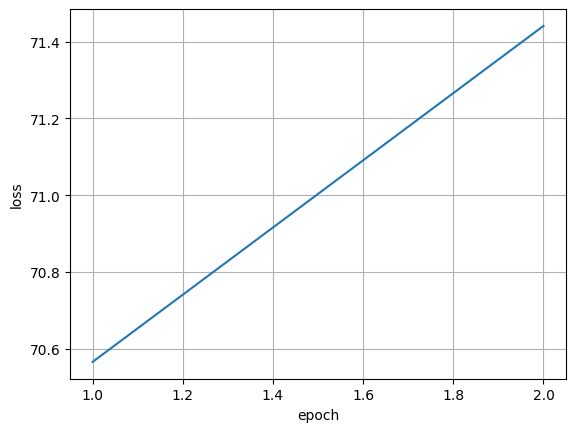

In [51]:
plt.plot([i for i in range(1, hparams['num_epochs']+1)], dev_accs)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

In [52]:
print(dev_accs)

[70.5659276546091, 71.44107351225205]


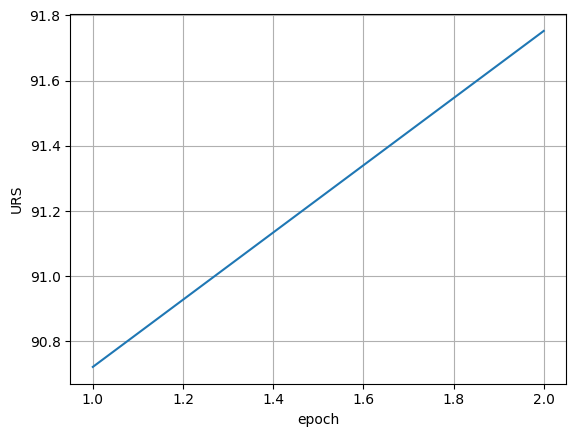

In [53]:
plt.plot([i for i in range(1, hparams['num_epochs']+1)], dev_urss)
plt.xlabel('epoch')
plt.ylabel('URS')
plt.grid()

In [54]:
dev_urss

[90.72164948453609, 91.75257731958763]

### Test

In [55]:
test_loss, test_acc, test_urs = eval_epoch(test_loader, model, criterion)


Test set: Average loss: 2.9435, Accuracy: 4172/8773 (47.554998%) , URS: 2224/2515 (88.429423%)



In [56]:
test_loss, test_acc, test_urs

(2.943461250175129, 47.554998290208594, 88.42942345924453)

## ?) Save model

In [57]:
#torch.save(model.state_dict(), 'gpt2_wav2vec2_transcript_seed_42.pt')